In [1]:
import Spectrogram
from librosa.core import note_to_hz, cqt
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
# parameters
# nargin = 6
bins = 24 # bins per octave
fs = 22050 # sampling rate
n_bins = 80
# fmax = 61.73541266 # same as 1 octave
fmax = 880*2
fmin = note_to_hz('A3')
thresh= 0.0054

stride = 512

s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*250*s, dtype=np.float32) + np.sin(2*np.pi*500*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32)  

# Pytorch

In [3]:
CQT_layer = Spectrogram.CQT1992(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins, norm=None,center=True,
                        pad_mode='reflect')
cqt_torch = CQT_layer(torch.tensor(x))

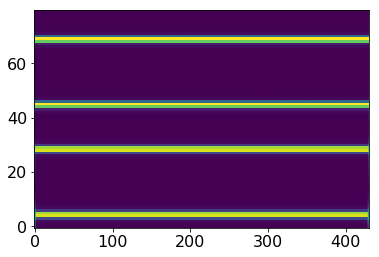

In [7]:
plt.imshow(cqt_torch[0].numpy(),aspect='auto', origin='lower')
plt.tick_params(labelsize=16)

# Librosa

In [6]:
from librosa.core import cqt

In [11]:
cqt_lib = cqt(x, fs, stride, fmin, n_bins=n_bins,
              bins_per_octave=bins, norm=None)

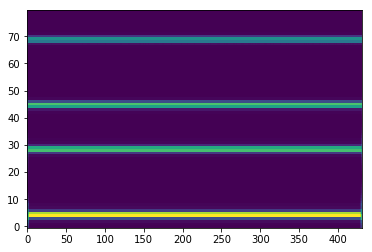

In [12]:
plt.imshow(abs(cqt_lib),aspect='auto', origin='lower')

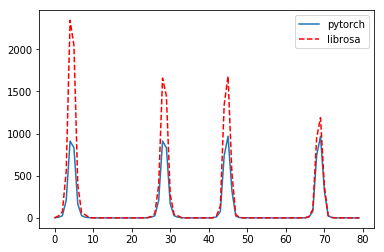

In [13]:
plt.plot(cqt_torch[0].numpy()[:,29])
plt.plot(abs(cqt_lib)[:,29], 'r--')
plt.legend(['pytorch', 'librosa'])